In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import glob

import gensim
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel

import pyLDAvis
from pyLDAvis import gensim_models 

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import re
import os
import sys
import ast
from textblob import TextBlob
from nrclex import NRCLex

import string
import spacy
nlp = spacy.load('en_core_web_sm')
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from datetime import datetime



c:\Users\ZBOOK\AppData\Local\r-miniconda\envs\sentiment_analysis\Lib\site-packages\tensorflow\python\debug\cli\debugger_cli_common.py:19: DeprecationWarning: module 'sre_constants' is deprecated
  import sre_constants


In [2]:
# nltk.download('stopwords')

In [35]:
five_g_data = pd.read_csv('5g_dataset.csv', sep=',', index_col= None) \
    .drop(columns='Unnamed: 0')

# five_g_data
#.sample(2)

In [36]:
# Extract exact dates

old_dates = five_g_data['created']

date_time = [datetime.utcfromtimestamp(date).strftime('%Y-%m-%d %H:%M:%S') for date in old_dates]

date = pd.to_datetime(date_time)

five_g_data['date'] = date.date
five_g_data = five_g_data.drop(columns='created').drop_duplicates()
# organic_food_reddit.sample(2)

In [37]:
x = five_g_data['subreddit'].unique().tolist()
len(x)

110

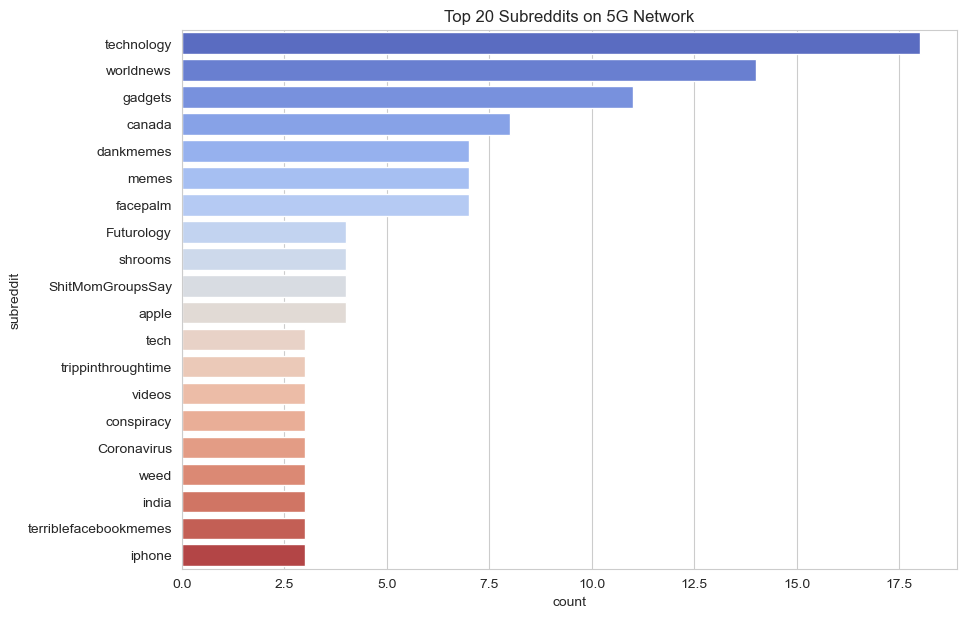

In [38]:
# Subreddits Descriptive Stats
sns.set_style('whitegrid')
subreddits = five_g_data['subreddit'].value_counts().sort_values(ascending=False).head(20).reset_index()
subreddits.shape
plt.figure(figsize=(10,7))
plt.title("Top 20 Subreddits on 5G Network")
sns.barplot(subreddits, x='count', y='subreddit', errorbar='sd', palette='coolwarm')
plt.show()


c:\Users\ZBOOK\AppData\Local\r-miniconda\envs\sentiment_analysis\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


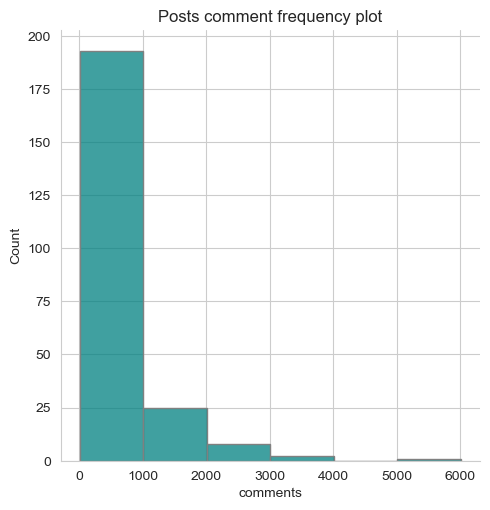

In [39]:
# Content comments / votes distribution

sns.displot(
    data=five_g_data, 
    x='comments', 
    binwidth = 1000, 
    color= 'teal', 
    edgecolor= 'gray')
plt.title('Posts comment frequency plot')
plt.show()

c:\Users\ZBOOK\AppData\Local\r-miniconda\envs\sentiment_analysis\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


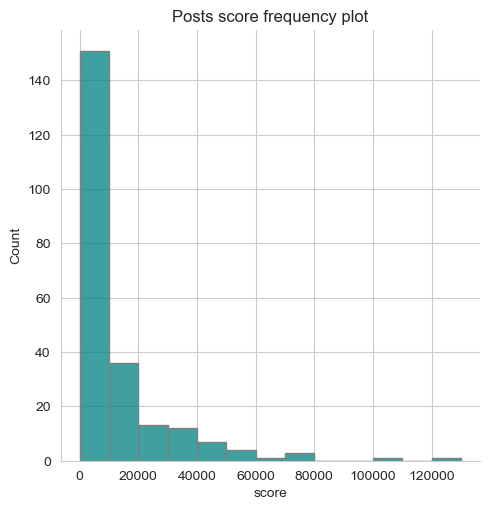

In [40]:
# Content score / votes distribution

sns.displot(
    data=five_g_data, 
    x='score', 
    binwidth = 10000, 
    color= 'teal', 
    edgecolor= 'gray')
plt.title('Posts score frequency plot')
plt.show()  

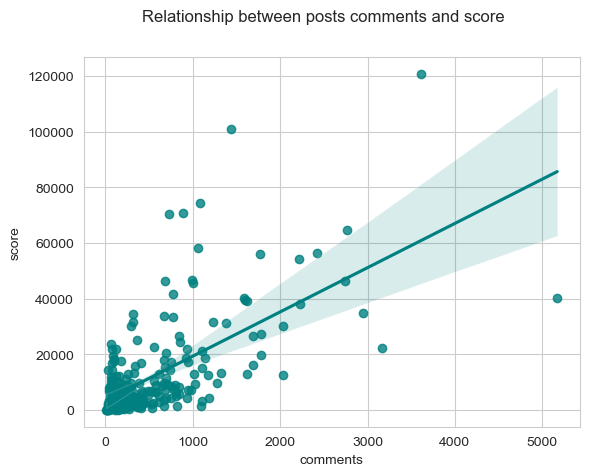

In [41]:
sns.set_style('whitegrid')
sns.regplot(five_g_data, x='comments', y='score', color='teal')
plt.suptitle('Relationship between posts comments and score')
plt.show()

In [42]:
# Handle words contractions

def handle_contractions(text):
    contractions = {
        "n't": " not",
        "'s" : " is",
        "'d" : " would",
        "'ve" : " have",
        "'re": " are",
        "'ll": " will",
        "'m": " am"
    }
    
    words = text.split()
    for i in range(len(words)):
        if words[i] in contractions:
            words[i] = contractions[words[i]]
    return ' '.join(words)


In [43]:
# Preprocess text, remove stopwords, tokenize and Lemmatize

def preprocess_text(text, freq_words=False):
    text = re.sub(r"\d+", '', text)
    text = text.lower()
    
    ## remove numbers from the text
    text = re.sub(r"\d+", '', text)
    
    ## removing punctuations
    text = ''.join([char for char in text if char not in string.punctuation])
    
    ## Tokenize text
    tokens = word_tokenize(text)
    
    ## Remove stopwords
    stop_words = stopwords.words("english")
    if freq_words:
        stop_words.extend(['g','G','£', '“', '’', '”', '‘'])
    tokens = [token for token in tokens if token not in stop_words]
    ## Remove contractions from words
    text = handle_contractions(' '.join(tokens))
    
    ## Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in word_tokenize(text)]
    
    return ' '.join(tokens)


In [44]:
five_g_data = five_g_data.fillna("")

In [45]:
five_g_data['cleaned_title'] = five_g_data['title'].apply(preprocess_text)

In [46]:
# Calculate sentiments

def percentage(val, total):
    return (val / total) * 100

# Sentiment Scores
def get_sentiment_scores(text_array):
    
    positive = 0
    negative = 0
    neutral = 0

    scores = []

    content_list = []

    positive_list = []
    negative_list = []
    neutral_list = []

    contents = text_array
    
    subjectivity_score = contents.apply(lambda x: TextBlob(x).sentiment.subjectivity)
    polarity_score = contents.apply(lambda x: TextBlob(x).sentiment.polarity)

    for content in contents:
        #print(content)
        content_list.append(content)
        score = SentimentIntensityAnalyzer().polarity_scores(content)
        neg_score = score['neg']
        pos_score = score['pos']
        neu_score = score['neu']    
        
        scores.append([neg_score, pos_score, neu_score])
        
        if neg_score > pos_score:
            negative_list.append(content)
            negative += 1
        elif neg_score < pos_score:
            positive_list.append(content)
            positive += 1
        elif neg_score == pos_score:
            neutral_list.append(content)
            neutral += 1
            
    positive = percentage(positive, len(contents))
    negative = percentage(negative, len(contents))
    neutral = percentage(neutral, len(contents))

    positive = format(positive, '.1f')
    negative = format(negative, '.1f')
    neutral = format(neutral, '.1f')
    
    
    return {
        'polarity': polarity_score,
        'subjectivity': subjectivity_score,
        'scores': scores,
        'positive': positive,
        'negative': negative,
        'neutral' : neutral
    }

In [47]:
# get sentiment scores
all_scores = get_sentiment_scores(five_g_data['cleaned_title'])

# add sentiment scores to dataframe
five_g_data_scores = five_g_data.reset_index()\
    .merge(pd.DataFrame(all_scores['scores'], columns=["neg", "pos", "neu"]).reset_index())

# add polarity and subjectivity scores to dataframe
five_g_data_scores['polarity'] = all_scores['polarity']
five_g_data_scores['subjectivity'] = all_scores['subjectivity']

# percentages of positive, negative and neutral
positive = all_scores['positive']
negative = all_scores['negative']
neutral = all_scores['neutral']

# attach sentiment scores
five_g_data_scores.loc[five_g_data_scores['neg'] > five_g_data_scores['pos'], "sentiment_label"] = "negative"
five_g_data_scores.loc[five_g_data_scores['pos'] > five_g_data_scores['neg'], "sentiment_label"] = "positive"
five_g_data_scores.loc[five_g_data_scores['neg'] == five_g_data_scores['pos'], "sentiment_label"] = "neutral"

five_g_data_scores.sample(2)

,index,title,subreddit,score,id,url,comments,body,date,cleaned_title,neg,pos,neu,polarity,subjectivity,sentiment_label
111,111,5G,GaySoundsShitposts,2352,wwi58x,https://i.redd.it/otvqica1nkj91.gif,47,,2022-08-24,g,0.0,0.0,0.0,0.0,0.0,neutral
131,131,"Wait, I thought it was 5G?",vaxxhappened,7917,qa0zgo,https://i.redd.it/us2c3dlh41u71.jpg,100,,2021-10-17,wait thought g,0.0,0.0,1.0,0.0,0.0,neutral


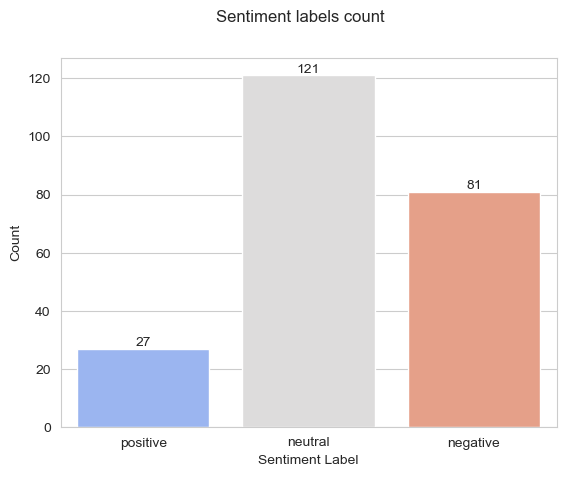

In [48]:
# sentiment labels barplot

plt.suptitle('Sentiment labels count')
sns.set_style('whitegrid')
ax = sns.countplot(data=five_g_data_scores, x="sentiment_label", palette='coolwarm', order=['positive', 'neutral', 'negative'])
ax.bar_label(ax.containers[0], fmt='%.0f', label_type = 'edge')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.show()

In [49]:
# five_g_data[five_g_data["score"]]
# neg_five_g = five_g_data_scores[five_g_data_scores['sentiment_label'] == "negative"]
cv = [date.year for date in five_g_data_scores['date']]

five_g_data_scores['year'] = cv



In [50]:
neg_five_g = five_g_data_scores[five_g_data_scores['sentiment_label'] == "negative"]
pos_five_g = five_g_data_scores[five_g_data_scores['sentiment_label'] == "positive"]
neu_five_g = five_g_data_scores[five_g_data_scores['sentiment_label'] == "neutral"]

neg_five_g = neg_five_g[['year','sentiment_label']].groupby("year").count()
pos_five_g = pos_five_g[['year','sentiment_label']].groupby("year").count()
# neu_five_g = neu_five_g[['year','sentiment_label']].groupby("year").count()

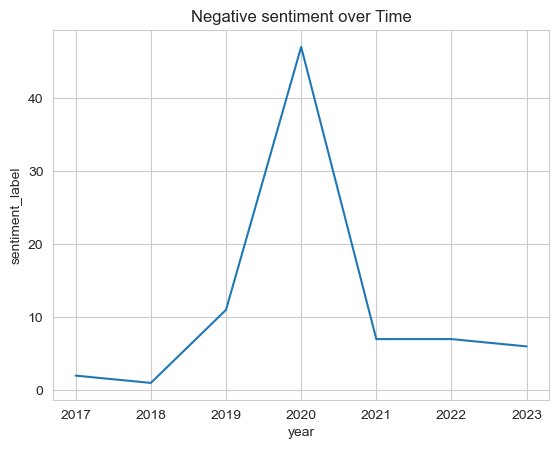

In [51]:
plt.title("Negative sentiment over Time")
sns.lineplot(
    data=neg_five_g,
    x="year", y="sentiment_label",
    markers=True, dashes=False
)
plt.show()

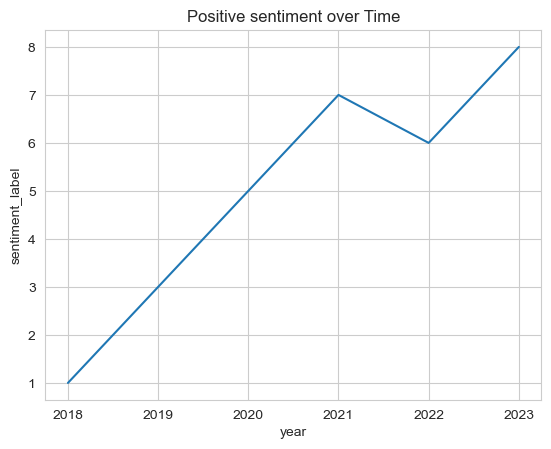

In [52]:
plt.title("Positive sentiment over Time")
sns.lineplot(
    data=pos_five_g,
    x="year", y="sentiment_label",
    markers=True, dashes=False
)
plt.show()

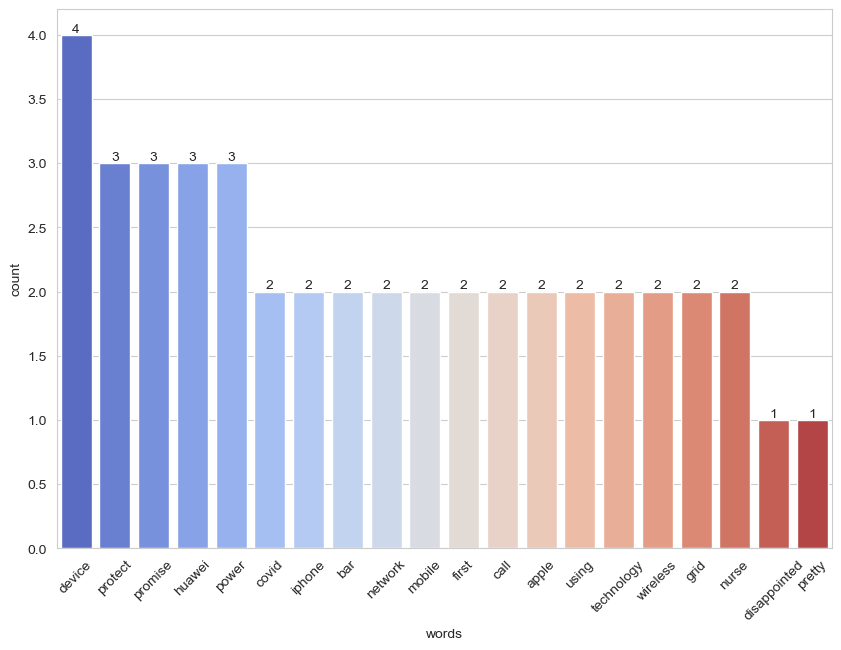

In [53]:

# word frequency for positive sentiments

positive_df = five_g_data_scores.loc[five_g_data_scores['sentiment_label'] == 'positive']['cleaned_title']
positive_words = " ".join(positive_df.apply(preprocess_text, freq_words = True))
words_count = Counter(positive_words.split())
most_freq = words_count.most_common(20)

fig = plt.figure(figsize=(10, 7))
_ = pd.DataFrame(most_freq, columns=("words", "count"))
ax = sns.barplot(x="words", y = "count", data=_, palette="coolwarm")
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0], fmt='%.0f', label_type = 'edge')
plt.show()

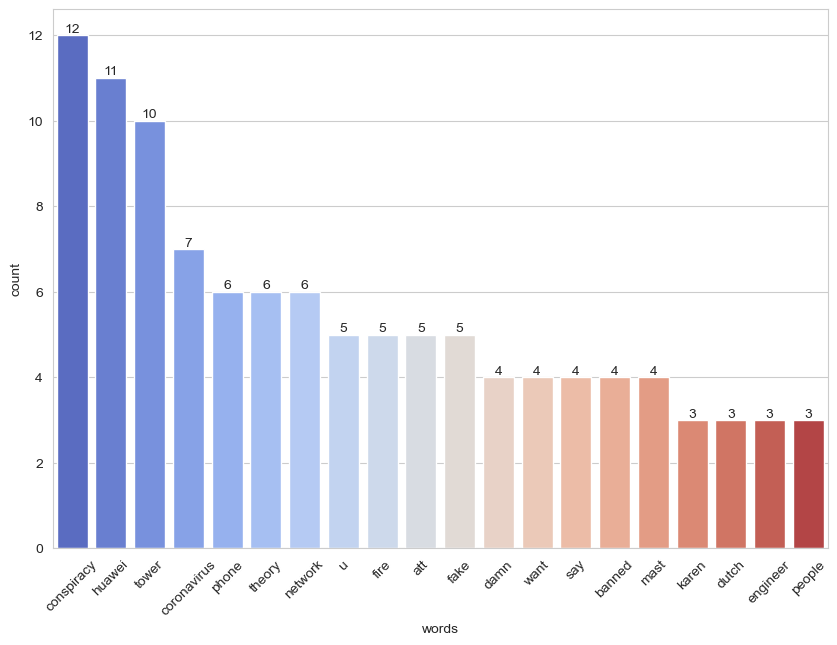

In [54]:
negative_df = five_g_data_scores.loc[five_g_data_scores['sentiment_label'] == 'negative']['cleaned_title']
negative_words = " ".join(negative_df.apply(preprocess_text, freq_words = True))
words_count = Counter(negative_words.split())
most_freq = words_count.most_common(20)

fig = plt.figure(figsize=(10, 7))
_ = pd.DataFrame(most_freq, columns=("words", "count"))
ax = sns.barplot(x="words", y = "count", data=_, palette="coolwarm")
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0], fmt='%.0f', label_type = 'edge')
plt.show()

c:\Users\ZBOOK\AppData\Local\r-miniconda\envs\sentiment_analysis\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


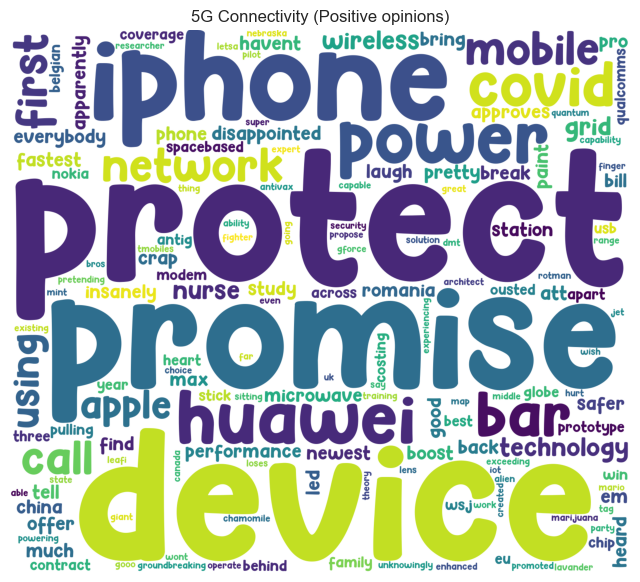

In [55]:
wordcloud_positive = WordCloud(
    background_color='white',
    max_words=150,
    height=1400,
    width=1600,
    font_path="hey_comic/Hey Comic.ttf"
).generate(positive_words)

plt.figure(figsize=(8,16))
plt.imshow(wordcloud_positive)
plt.title("5G Connectivity (Positive opinions)")
plt.axis('off')
plt.show()


c:\Users\ZBOOK\AppData\Local\r-miniconda\envs\sentiment_analysis\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


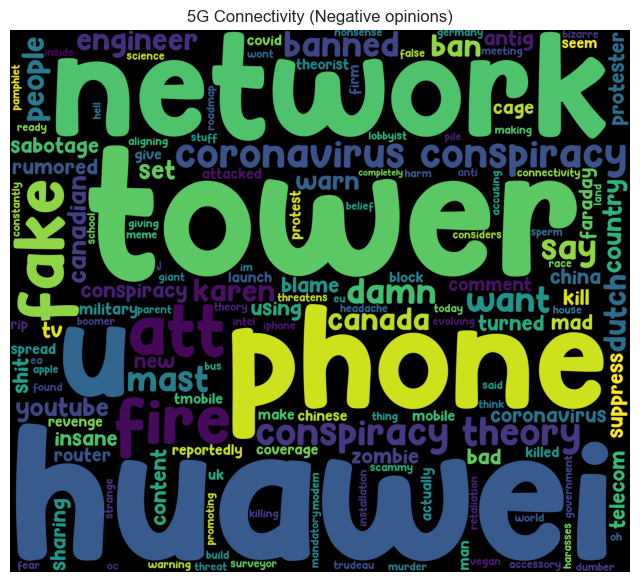

In [56]:
wordcloud_negative = WordCloud(
    background_color='black',
    max_words=150,
    height=1400,
    width=1600,
    font_path="hey_comic/Hey Comic.ttf"
).generate(negative_words)

plt.figure(figsize=(8,16))
plt.imshow(wordcloud_negative)
plt.title("5G Connectivity (Negative opinions)")
plt.axis('off')
plt.show()

c:\Users\ZBOOK\AppData\Local\r-miniconda\envs\sentiment_analysis\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


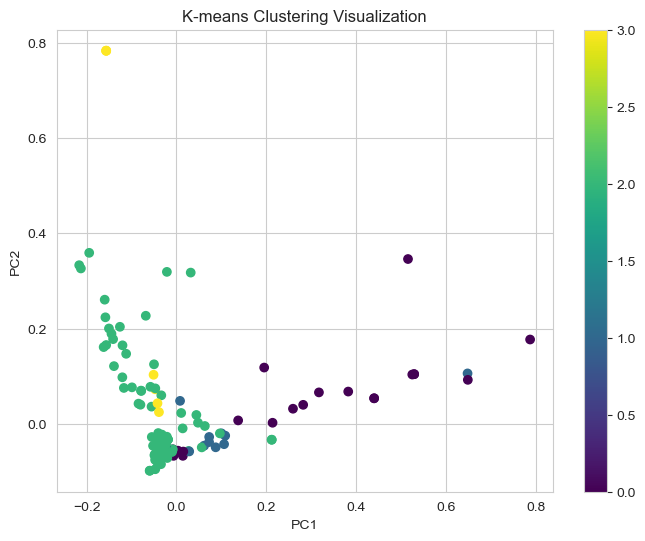

In [57]:
# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer()
# Apply TF-IDF vectorization to the processed feedback text
tfidf_matrix = vectorizer.fit_transform(five_g_data['cleaned_title'])
# Perform K-means clustering
num_clusters = 4 # Specify the desired number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(tfidf_matrix)
# Assign cluster labels to the feedback data
five_g_data['Cluster'] = kmeans.labels_
# Apply dimensionality reduction using PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(tfidf_matrix.toarray())
# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=five_g_data['Cluster'], cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-means Clustering Visualization')
plt.colorbar()
plt.show()
# Print the top terms for each cluster

In [58]:
print("Top terms per cluster:")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in range(num_clusters):
    print(f"Cluster {i}:")
    for ind in order_centroids[i, :10]:
        print(f" {terms[ind]}")
    print()

Top terms per cluster:
Cluster 0:
 tower
 phone
 baby
 turn
 sabotage
 protester
 att
 dutch
 cause
 coronavirus

Cluster 1:
 conspiracy
 coronavirus
 going
 theory
 youtube
 content
 suppress
 tower
 vegan
 belief

Cluster 2:
 huawei
 network
 say
 damn
 know
 canada
 got
 antig
 get
 internet

Cluster 3:
 covid
 indian
 point
 government
 also
 india
 cause
 say
 network
 nurse



In [59]:
# Bag of words model

# create dictionary
five_g_data_scores['cleaned_title_list'] = [list(sent.split()) for sent in five_g_data_scores['cleaned_title'].apply(preprocess_text, freq_words = True)]
id2word = gensim.corpora.Dictionary(five_g_data_scores['cleaned_title_list'])

corpus = [id2word.doc2bow(text) for text in five_g_data_scores['cleaned_title_list']]

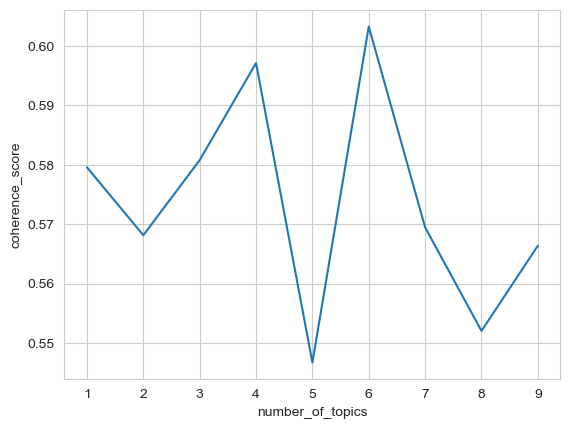

In [60]:
# Using coherence model to determine the number of topics

num_topics = []
coherence_score = []

text = five_g_data_scores['cleaned_title_list']

for i in range(1, 10):
    lda_model = LdaModel(corpus=corpus, id2word = id2word, iterations = 50, num_topics = i)
    coherence_model = CoherenceModel(model=lda_model, texts=text, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model.get_coherence()
    num_topics.append(i)
    coherence_score.append(coherence_lda)
    
# Create a dataframe of coherence score by number of topics
topic_coherence = pd.DataFrame({'number_of_topics': num_topics,
                                'coherence_score': coherence_score})

sns.lineplot(data=topic_coherence, x='number_of_topics', y='coherence_score')
plt.show()

In [61]:
# Topic modelling with LDA (Latent Dirichlet Allocation)

# number of topics
n_topics = 4

lda_model = LdaModel(
    corpus=corpus, 
    id2word=id2word, 
    num_topics=n_topics, 
    random_state=100, 
    update_every=1, 
    chunksize=10,
    passes=10,
    alpha='symmetric',
    iterations=100
    # per_word_topics=True
)

for idx, topic in lda_model.print_topics(-1):
    print(f"Topic: {idx} Word: {topic}")


Topic: 0 Word: 0.024*"huawei" + 0.023*"network" + 0.014*"coronavirus" + 0.013*"conspiracy" + 0.013*"theory" + 0.012*"tower" + 0.010*"mast" + 0.009*"canadian" + 0.008*"say" + 0.008*"country"
Topic: 1 Word: 0.021*"u" + 0.013*"phone" + 0.010*"could" + 0.009*"iphone" + 0.008*"device" + 0.008*"apple" + 0.008*"launch" + 0.008*"th" + 0.007*"plan" + 0.007*"using"


In [62]:
# Visualize with pyLDAvis

pyLDAvis.enable_notebook()

vis = gensim_models.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=             x    y  topics  cluster      Freq
topic                                         
0      0.10683  0.0       1        1  53.74277
1     -0.10683  0.0       2        1  46.25723, topic_info=            Term       Freq      Total Category  logprob  loglift
87        huawei  15.000000  15.000000  Default  30.0000  30.0000
2              u  11.000000  11.000000  Default  29.0000  29.0000
34       network  14.000000  14.000000  Default  28.0000  28.0000
193  coronavirus   9.000000   9.000000  Default  27.0000  27.0000
79         phone   7.000000   7.000000  Default  26.0000  26.0000
..           ...        ...        ...      ...      ...      ...
53         antig   3.326747   4.468744   Topic2  -5.0728   0.4758
516      protest   2.539209   3.165197   Topic2  -5.3430   0.5506
518        warns   2.646354   3.797747   Topic2  -5.3016   0.4097
581          set   2.941946   5.489269   Topic2  -5.1958   0.1472
225          new   2.553282   4.306549   Topic2  -5.3374   0.2482

[105 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
399       2  1.074906  android
53        1  0.223777    antig
53        2  0.671330    antig
133       2  0.901223    apple
142       2  0.955907      att
...     ...       ...      ...
2         2  0.951936        u
552       1  0.804310       uk
26        2  1.007759    using
518       1  0.263314    warns
518       2  0.789942    warns

[85 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

#### Topic 0: Conspiracy Theories and 5G
**Key Words: "network", "tower", "coronavirus", "conspiracy", "theory", "covid"**

Interpretation: This topic seems to revolve around conspiracy theories related to 5G technology and its alleged connection to the spread of the coronavirus (COVID-19). It's well-known that there have been unfounded claims associating 5G networks with health issues and the pandemic, which is addressed in this topic.


#### Topic 1: Technology and 5G Devices
**Key Words: "mast", "could", "set", "fire", "device", "attacked"**

Interpretation: This topic appears to discuss the technological aspects of 5G, including network infrastructure ("mast"), potential issues ("fire"), and the security or vulnerabilities of 5G devices. The word "attacked" may suggest discussions on potential cybersecurity threats to 5G networks.


#### Topic 2: 5G and Technology Companies
**Key Words: "huawei", "phone", "canadian", "country", "canada", "banned"**

Interpretation: This topic is likely related to the involvement of technology companies in 5G deployment. "Huawei" is a prominent telecommunications equipment manufacturer, and discussions about its role in supplying 5G infrastructure are included. "Banned" suggests the controversy surrounding the use of Huawei's technology in certain countries, such as Canada.


#### Topic 3: 5G and Mobile Devices
**Key Words: "u," "iphone," "launch," "apple," "th"**

Interpretation: This topic appears to be about the launch of 5G-capable mobile devices, with specific reference to Apple's iPhone. It may discuss the rollout of 5G technology in mobile devices and the impact on the consumer market.

In [63]:
for topic_id in range(lda_model.num_topics):
    term_freqs = lda_model.get_topic_terms(topic_id)
    topic_size = len(lda_model.get_topic_terms(topic_id))
    print(f"Topic {topic_id}: Term Frequency - {term_freqs}, Topic Size - {topic_size}")

Topic 0: Term Frequency - [(87, 0.02406939), (34, 0.022752946), (193, 0.014215435), (37, 0.013219687), (264, 0.012561045), (38, 0.011526997), (609, 0.010355725), (318, 0.008586893), (36, 0.008131795), (319, 0.0076125516)], Topic Size - 10
Topic 1: Term Frequency - [(2, 0.02097862), (79, 0.013154294), (462, 0.010035874), (135, 0.008888022), (351, 0.007914818), (133, 0.0077559147), (411, 0.0077212327), (345, 0.007565446), (589, 0.0071990415), (26, 0.0069444687)], Topic Size - 10


In [64]:
for doc_id, doc in enumerate(corpus):
    print(doc)
    topic_distribution = lda_model[doc]
    print(topic_distribution)
    max_topic, max_prob = max(topic_distribution, key=lambda x: x[1])
    print(f"Document {doc_id} is primarily associated with Topic {max_topic} with probability {max_prob}")

[(0, 1), (1, 1), (2, 1)]
[(0, 0.1347154), (1, 0.8652846)]
Document 0 is primarily associated with Topic 1 with probability 0.8652846217155457
[(3, 1), (4, 1), (5, 1), (6, 1)]
[(0, 0.121871494), (1, 0.8781285)]
Document 1 is primarily associated with Topic 1 with probability 0.8781285285949707
[(7, 1), (8, 1), (9, 1), (10, 1)]
[(0, 0.1360863), (1, 0.8639137)]
Document 2 is primarily associated with Topic 1 with probability 0.8639137148857117
[(11, 1), (12, 1)]
[(0, 0.18926273), (1, 0.8107373)]
Document 3 is primarily associated with Topic 1 with probability 0.8107373118400574
[(13, 1), (14, 1), (15, 1), (16, 1)]
[(0, 0.44222072), (1, 0.55777925)]
Document 4 is primarily associated with Topic 1 with probability 0.5577792525291443
[(17, 1)]
[(0, 0.34632358), (1, 0.65367645)]
Document 5 is primarily associated with Topic 1 with probability 0.653676450252533
[(15, 1), (18, 1), (19, 1), (20, 1)]
[(0, 0.111843124), (1, 0.88815683)]
Document 6 is primarily associated with Topic 1 with probabil